In [87]:
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from load_and_prepare_data_functions import load_and_subsample_series, split_training_data

In [88]:
def mse_function(answer, prediction):
    mse = ((answer - prediction)**2).mean(axis=0)
    for i in range(len(answer.shape)-1):
        mse = mse.mean(axis=0)
    return mse

Data to test on

In [89]:
# Variables relating to the data you want to load
system = 'Lorentz'
x_transformation_type = 0
number_of_data_points = 10000
length_of_subsequence = 20
number_timesteps_predict = 10

In [90]:
c_array = [30,40,50,60,70,80,90,100,110,120,130,140,150,175,200,225,250,275,300,400,500,600,700,800,900,1000]

name = f"{system}_{number_of_data_points}"
# train_filename = f'data_dictionaries/data_{name}.npy'
test_filename = f'data_dictionaries/data_testing_{name}.npy'
# train_data_dictionary = np.load(train_filename, allow_pickle=True).item()
test_data_dictionary = np.load(test_filename, allow_pickle=True).item()
# train_observations = train_data_dictionary["observations"]
test_observations = test_data_dictionary["observations"]

# Load the mse dictionary
mse_dictionary_savename = f"{system}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
mse_dictionary_filename = f'saved_models/{system}/timesteps_{number_timesteps_predict}/mse_dictionary_{mse_dictionary_savename}.npy'
mse_dictionary = np.load(mse_dictionary_filename , allow_pickle = True).item()

# mse_dictionary = {}
mse_dictionary['MLonly_loss'] = []
if f'x_transformation_{x_transformation_type}' not in mse_dictionary:
    mse_dictionary[f'x_transformation_{x_transformation_type}'] = {}
    mse_dictionary[f'x_transformation_{x_transformation_type}']['mse_imperfect_predictions'] = {}
    mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_loss'] = {}
    mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_error_loss'] = {}

for i, c in enumerate(c_array):
    print(str(c).replace('.', ''))
    test_predictions = test_data_dictionary[f'timesteps_{number_timesteps_predict}'][f'x_transformation_{x_transformation_type}'][c]

    # Calculate the mean squared error between the true observation and the imperfect model's prediction
    finalmse = mse_function(test_observations[number_timesteps_predict:,:], test_predictions[:-number_timesteps_predict,:])
    print(f"mse of imperfect predictions = {finalmse}")
    mse_dictionary[f'x_transformation_{x_transformation_type}']['mse_imperfect_predictions'][c] = finalmse

    if c != np.inf:
        # Load the observations
        observations, predictions = load_and_subsample_series(number_of_data_points,
                                                              system,
                                                              length_of_subsequence + number_timesteps_predict,
                                                              number_timesteps_predict = number_timesteps_predict,
                                                              x_transformation_type = x_transformation_type,
                                                              c = c,
                                                              filename = test_filename)

        # Split into training and test data
        train_X, test_X, train_answer, test_answer = split_training_data(observations,
                                                                         number_timesteps_predict,
                                                                         predictions = predictions,
                                                                         frac=0)

        # Physical ML model
        save_name = f"{system}{x_transformation_type}_c{str(c).replace('.', '')}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
        save_filepath = f'saved_models/{system}/timesteps_{number_timesteps_predict}/x_transformation_{x_transformation_type}/physical_{save_name}.keras'
        loaded_model = keras.models.load_model(save_filepath)
        loss_physical = loaded_model.evaluate(x = test_X, y = test_answer)
        print(f"loss physical = {loss_physical}")
        mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_loss'][c] = loss_physical

        # Physical error ML model
        save_filepath = f'saved_models/{system}/timesteps_{number_timesteps_predict}/x_transformation_{x_transformation_type}/physical_error_{save_name}.keras'
        loaded_model = keras.models.load_model(save_filepath)
        loss_physical_error = loaded_model.evaluate(x = test_X, y = test_answer - test_X['input_pred'])
        print(f"loss physical error = {loss_physical_error}")
        mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_error_loss'][c] = loss_physical_error

MLonly_name = f"{system}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
MLonly_filepath = f'saved_models/{system}/timesteps_{number_timesteps_predict}/MLonly_{MLonly_name}.keras'
MLonly_model = keras.models.load_model(MLonly_filepath)
MLonly_loss = MLonly_model.evaluate(x = test_X['input_ob'], y = test_answer)
print(f'ML only loss = {MLonly_loss}')
mse_dictionary['MLonly_loss'].append(MLonly_loss)
for i in range(5):
    MLonly_name = f"{system}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
    MLonly_filepath = f'saved_models/{system}/timesteps_{number_timesteps_predict}/MLonly_epochtest{i}_{MLonly_name}.keras'
    MLonly_model = keras.models.load_model(MLonly_filepath)
    MLonly_loss = MLonly_model.evaluate(x = test_X['input_ob'], y = test_answer)
    print(f'ML only loss = {MLonly_loss}')
    mse_dictionary['MLonly_loss'].append(MLonly_loss)

np.save(mse_dictionary_filename, mse_dictionary)

191/312 [=================>............] - ETA: 1s - loss: 0.0011Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/hf/qjztdgps209_wl7gb22k35zh0000gn/T/ipykernel_1974/3480487977.py", line 68, in <module>
    MLonly_loss = MLonly_model.evaluate(x = test_X['input_ob'], y = test_answer)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/ariannacox/PycharmProjects/ChaosML/venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 2200, in evaluate
    logs = test_function_runner.run_step(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/User

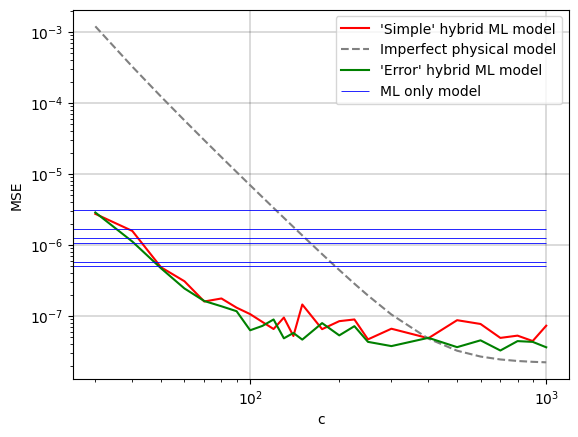

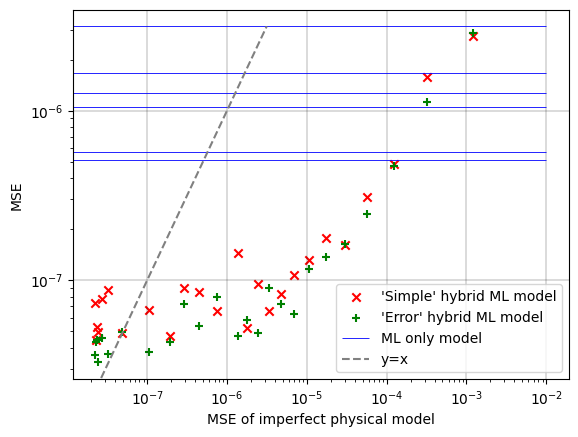

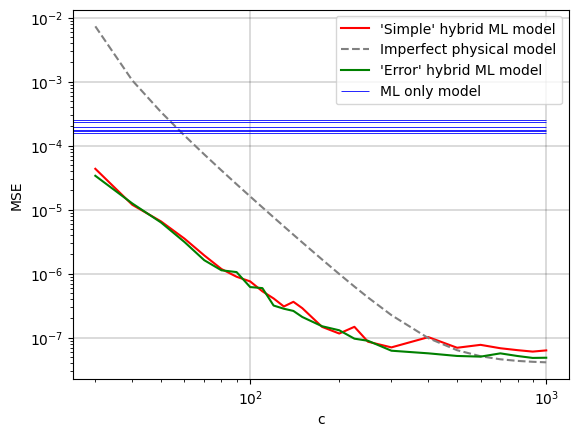

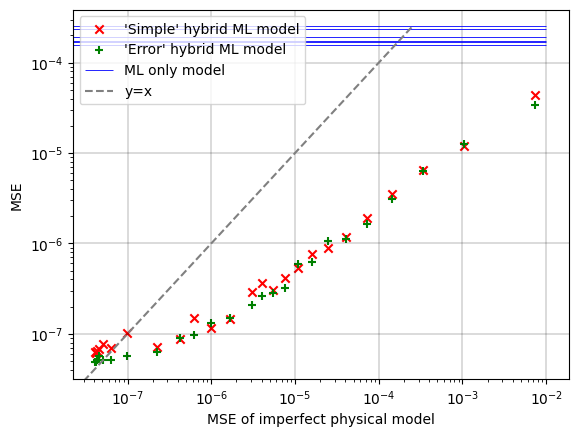

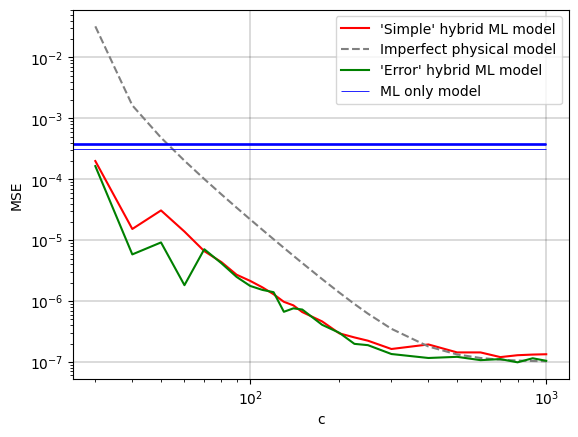

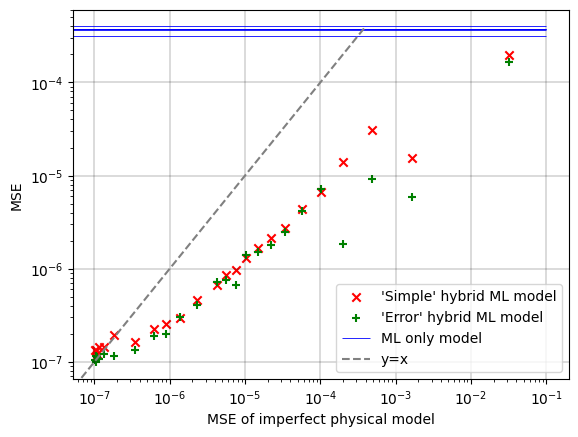

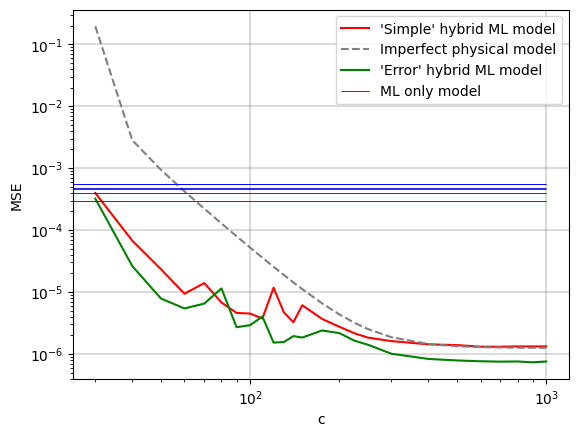

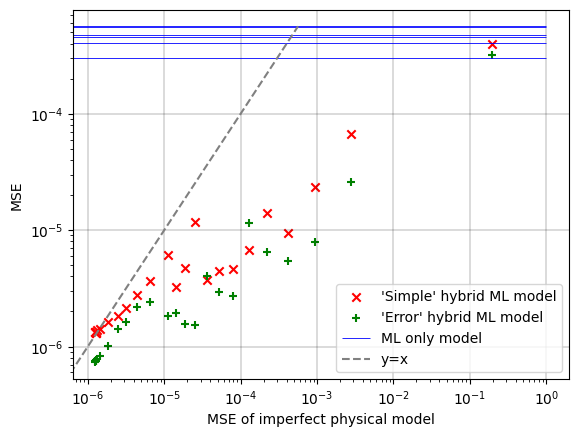

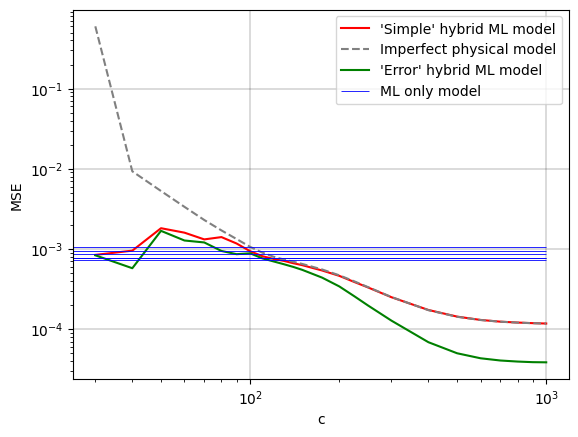

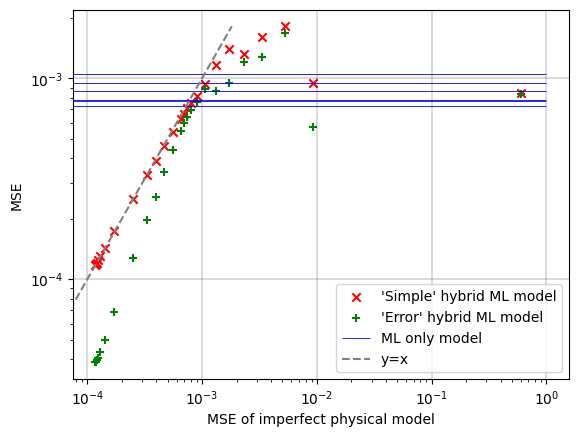

In [92]:
for number_timesteps_predict in [1,2,3,5,10]:
    name = f"{system}_{number_of_data_points}"
    c_array = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140 ,150, 175, 200, 225, 250, 300, 400, 500, 600, 700, 800, 900, 1000]

    mse_dictionary_savename = f"{system}_{number_of_data_points}_{length_of_subsequence}_{number_timesteps_predict}"
    mse_dictionary_filename = f'saved_models/{system}/timesteps_{number_timesteps_predict}/mse_dictionary_{mse_dictionary_savename}.npy'
    mse_dictionary = np.load(mse_dictionary_filename , allow_pickle = True).item()

    finalmse = np.zeros(len(c_array))
    loss_physical = np.zeros(len(c_array))
    loss_physical_error = np.zeros(len(c_array))
    MLonly_loss = mse_dictionary['MLonly_loss']
    # mse_perfect_model_prediction = mse_dictionary[[f'x_transformation_{x_transformation_type}']]['mse_imperfect_predictions'][np.inf]

    for i, c in enumerate(c_array):
        finalmse[i] = mse_dictionary[f'x_transformation_{x_transformation_type}']['mse_imperfect_predictions'][c]
        loss_physical[i] = mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_loss'][c]
        loss_physical_error[i] = mse_dictionary[f'x_transformation_{x_transformation_type}']['physical_error_loss'][c]


    plt.plot(c_array, loss_physical, '-', label = '\'Simple\' hybrid ML model', color = 'r')
    plt.plot(c_array,finalmse,'--', label = 'Imperfect physical model', color = 'grey')
    plt.plot(c_array, loss_physical_error, '-', label = '\'Error\' hybrid ML model', color = 'g')
    plt.hlines(MLonly_loss, 0,1000, label = 'ML only model', color = 'b', linewidth = 0.6)
    # plt.hlines(mse_perfect_model_prediction, 0,1000, linestyle = '-.', label = 'perfect model', color = 'b')
    # plt.hlines(3*10**(-8), 0,1000, linestyle = '--', label = 'noise', color = 'grey')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('c')
    plt.ylabel('MSE')
    plt.grid(which='major', color='black', linestyle='-', linewidth = 0.2)
    # plt.grid(which='minor', color='grey', linestyle='-')
    plt.legend()
    # plt.title(f'mse against c when predicting {number_timesteps_predict} timesteps ahead')
    plt.savefig(f'final_graphs/mse_vs_c_timesteps{number_timesteps_predict}_{name}_corrected')
    plt.show()

    plt.scatter(finalmse, loss_physical, marker = 'x', label = '\'Simple\' hybrid ML model', color = 'r')
    plt.scatter(finalmse, loss_physical_error, marker='+', label = '\'Error\' hybrid ML model', color = 'g')
    plt.hlines(MLonly_loss, 0, 10**(1+np.floor(np.log10(np.amax(finalmse)))), label = 'ML only model', color = 'b', linewidth = 0.6)
    # plt.hlines(mse_perfect_model_prediction, 0,10**(-3), linestyle = '-.', label = 'perfect model', color = 'b')
    # plt.hlines(3*10**(-8), 0,1, linestyle = '-.', label = 'perfect model', color = 'b')
    plt.plot([0,np.max([np.amax(loss_physical), np.amax(MLonly_loss)])], [0, np.amax([np.amax(loss_physical),np.amax(MLonly_loss)])], '--', label = 'y=x', color = 'grey')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('MSE of imperfect physical model')
    plt.ylabel('MSE')
    plt.grid(which='major', color='black', linestyle='-', linewidth = 0.2)
    # plt.grid(which='minor', color='grey', linestyle='-')
    plt.legend()
    # plt.title(f'mse against imperfect model mse when predicting {number_timesteps_predict} timesteps ahead')
    plt.savefig(f'final_graphs/mse_vs_mse_timesteps{number_timesteps_predict}_{name}_corrected')
    plt.show()
